<font size=4>
In the last notebook we had a quick intro to gradient descent, where we used it to find the parameters of some function. Here we're going to do the same thing, but using a neural network.
</font>

In [8]:
import torch.nn as nn # has all the neural net functions we'll need
import torch
import numpy as np

import matplotlib.pyplot as plt 
from matplotlib import animation
from IPython.display import HTML

<font size=4>
We'll use, for now, the same input and target function as before, which are both 1-dimensional.
</font>

In [4]:
N_samples = 10_000

inputs = torch.rand(10_000, 1) - 0.5 # random values between -1/2 and 1/2
inputs = inputs*2 # now random values between -2 and 2

print("inputs shape", inputs.shape)

def f(x): return 16*x**5 - 20*x**3 + 5*x # this is the "correct" function that will generate our input/output data pairs. This is a Chebychev polynomial that I chose at random.

outputs = f(inputs)
outputs_noisy = f(inputs) + torch.randn_like(inputs)*0.1 # noise amplitude is 0.1

print("outputs shape", outputs.shape)

inputs shape torch.Size([10000, 1])
outputs shape torch.Size([10000, 1])


Text(0.5, 1.0, 'Slightly noisy data')

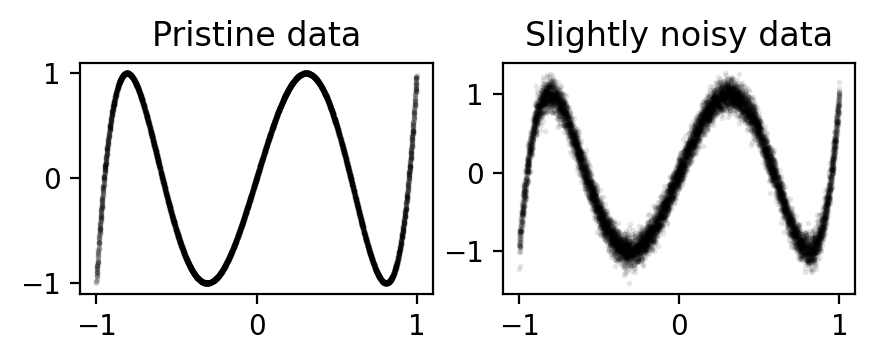

In [5]:
fig,ax=plt.subplots(1,2,figsize=(5,1.5),dpi=200)

ax[0].scatter(inputs, outputs, s=4, color='k', alpha=0.1, lw=0)
ax[1].scatter(inputs, outputs_noisy, s=4, color='k', alpha=0.1, lw=0)

ax[0].set_title("Pristine data")
ax[1].set_title("Slightly noisy data")

# Neural networks

<font size=4>
Neural networks are essentially big functions that are characterized by a bunch of <b>parameters</b>.

The two essential methods of the network are `init`, which will create the network, and `forward` which determines how the network computes an output given some input value.

We are going to make a network out of linear layers, together with activation functions. A linear layer maps an input $x_{in}$ to an output $x_{out}$ according to
$$x_{out} = W\cdot x_{in} + b$$
where $W$ is a matrix ('W' for 'weights') and $b$ is a vector (b for 'bias') of the same shape as $x_{out}$. If $x_{in}$ has dimension $d_{in}$ and $x_{out}$ has dimension $d_{out}$, then $W$ has shape $d_{out} \times d_{in}$.

The above equation is actually not quite true - I forgot the activation function, which I'll call $\phi$. $\phi(x)$ acts element-wise on a vector $x$. The true value of $x_{out}$ is then
$$x_{out} = \phi(W\cdot x_{in} + b)$$

</font>

In [18]:
class NNModel(nn.Module):
    def __init__(self, 
                 input_size=1, # number of channels/dimensions of the input
                 output_size=1, # number of channels/dimensions of the output
                 n_channels=64, # number of channels/dimensions of inner layers
                 n_layers=2, # number of intermediate layers
                 activation_fct=nn.ReLU(),
                 optimization_hyperparameters={'LR': 1e-3}):

        super().__init__() # initialize nn.Module

        ## MAKE THE NETWORK
        self.layers = nn.ModuleList() # this will be a list of all our neural network layers. You can append to it just like to a normal list

        self.layers.append(nn.Linear(input_size, n_channels)) # First layer
        self.layers.append(activation_fct) # Activation on first layer

        for _ in range(n_layers-1):
            self.layers.append(nn.Linear(n_channels, n_channels)) # intermediate layer
            self.layers.append(activation_fct) # activation
        
        self.layers.append(nn.Linear(n_channels, output_size)) # Last layer. Don't activate, unless you want values in [0, infty] 


        ## MAKE THE OPTIMIZER. 
        # This will keep track of things like learning rate, optimization steps, and which parameters we want to apply gradients to.
        # self.parameters will get all the parameters in the layers that we have initialized so far, so make sure to do this step last.
        self.optimizer = torch.optim.Adam(self.parameters(), lr=optimization_hyperparameters['LR'])



    def forward(self, input):
        x = input.clone()

        for layer in self.layers:
            x = layer(x) # apply each layer to the input
            
        return x # this is our prediction


In [42]:
model = NNModel(input_size=1, # number of channels/dimensions of the input
                 output_size=1, # number of channels/dimensions of the output
                 n_channels=64, # number of channels/dimensions of inner layers
                 n_layers=2, # number of intermediate layers
                 activation_fct=nn.ReLU(),
                 optimization_hyperparameters={'LR': 1e-3})

# FOR YOU TO DO!
The network (in the case of `n_layers=2`) is computing a function $f_{NN}=W_3 \phi(W_2 \phi (W_1 x + b_1) + b_2 )$.
What are the shapes of $W_{1-3}$, $b_{1-2}$?


(-2.0, 2.0)

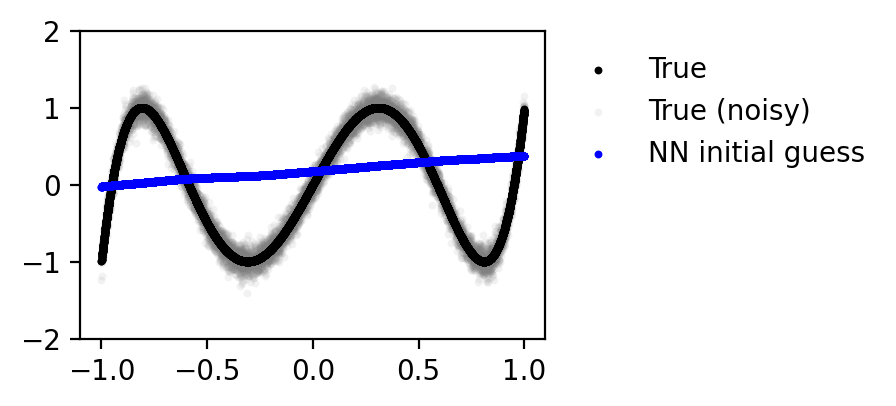

In [43]:
fig,ax=plt.subplots(1,1,figsize=(3,2),dpi=200)

ax.scatter(inputs, outputs, s=8, color='k', alpha=1, lw=0, label='True')
ax.scatter(inputs, outputs_noisy, s=8, color='gray', alpha=0.1, lw=0, label='True (noisy)', zorder=-1)
ax.scatter(inputs, model(inputs).detach(), s=8, color='b', alpha=1, lw=0, label='NN initial guess')

ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0), frameon=False)
ax.set_ylim(-2,2)

# Gradient descent applied to our data

In [45]:
prediction_history = []
loss_history = []

for step in range(1000):
    model.optimizer.zero_grad() # clear any gradients, so that we can calculate them anew

    predictions = model(inputs)

    loss = torch.mean((predictions - outputs)**2) # here I do mean (instead of sum) to keep the values of the loss small. Otherwise they can blow up.
    
    loss.backward() # calculate gradients
    model.optimizer.step() # will do a gradient step

    loss_history.append(loss.detach())
    prediction_history.append(predictions.detach().cpu().numpy())


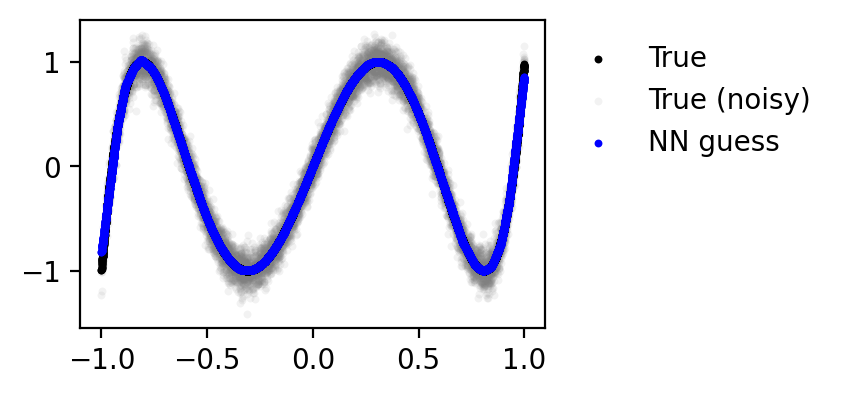

In [39]:
fig,ax=plt.subplots(1,1,figsize=(3,2),dpi=200)

ax.scatter(inputs, outputs, s=8, color='k', alpha=1, lw=0, label='True')
ax.scatter(inputs, outputs_noisy, s=8, color='gray', alpha=0.1, lw=0, label='True (noisy)', zorder=-1)
ax.scatter(inputs, model(inputs).detach().cpu(), s=8, color='b', alpha=1, lw=0, label='NN guess')

ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0), frameon=False)

In [40]:
def plot_evolving_loss_and_curve(predictions, loss_vals, lineclr = 'k', linealpha=0.99, interval=20):
    def init():
        scat.set_offsets(np.asarray([inputs.squeeze(), predictions[0].squeeze()]).T) # takes Nx2 array
        line.set_data([[0], [loss_vals[0]]])

        return (scat, line)
    
    def animate(i):
        scat.set_offsets(np.asarray([inputs.squeeze(), predictions[i].squeeze()]).T) # takes Nx2 array
        line.set_data([np.arange(i), loss_vals[:i]])

        ax[0].set_title(f'Loss = {loss_vals[i].detach().squeeze():0.2f}')
    
        return (scat, line)

    
    
    fig,ax=plt.subplots(1,2,figsize=(5,2),dpi=200)
    
    ax[0].scatter(inputs, outputs, s=8, color='k', alpha=1, lw=0, label='True')
    ax[0].scatter(inputs, outputs_noisy, s=8, color='gray', alpha=0.1, lw=0, label='True (noisy)', zorder=-1)
    scat = ax[0].scatter(inputs, predictions[0], s=8, color='b', alpha=1, lw=0, label='NN guess')
    
    line, = ax[1].plot([0], [loss_vals[0]], color='r')
    
    ax[1].set_xlim(0, len(loss_vals))
    ax[1].set_ylim(np.min(loss_vals), np.max(loss_vals))
    ax[1].set_yscale('log')
    ax[1].set_title('Loss')
    ax[1].set_xlabel('N Steps')
    
    plt.close();
    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(loss_vals), interval=interval, blit=True)
    return anim


In [41]:
HTML(plot_evolving_loss_and_curve(prediction_history[::20], loss_history[::20], interval=20, lineclr='k', linealpha=0.1).to_html5_video())

# THINGS FOR YOU TO TRY!
1) Try putting the model on the gpu!
2) Make a plot of how the final loss (attained after some number of steps that you can decide) depends on:
     - learning rate (do a log-scale sweep, from (for example) 1e-1 to 1e-5)
     - number of channels and/or layers
     - activation function (look up some common ones)

# Some other useful functions for neural networks

<font size=4>
Print them:
</font>

In [46]:
print(model)

NNModel(
  (layers): ModuleList(
    (0): Linear(in_features=1, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)


<font size=4>
Look at the parameters (weights/biases)
</font>

In [52]:
# This will show all the parameters, together with their "names"
[[n, p.shape] for n,p in model.named_parameters()]

[['layers.0.weight', torch.Size([64, 1])],
 ['layers.0.bias', torch.Size([64])],
 ['layers.2.weight', torch.Size([64, 64])],
 ['layers.2.bias', torch.Size([64])],
 ['layers.4.weight', torch.Size([1, 64])],
 ['layers.4.bias', torch.Size([1])]]

 <font size=5>
<b>Question for you: Why do layers 1, 3 not have names?</b>
</font>

<font size=4>
Let's plot some of the weights
</font>

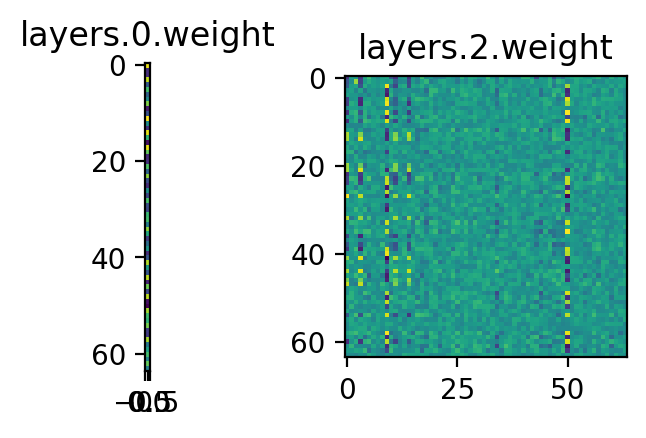

In [61]:
weights_to_plot = ['layers.0.weight', 'layers.2.weight']

named_weight_dict = {n: p for n,p in model.named_parameters()}

fig,ax=plt.subplots(1, len(weights_to_plot), figsize=(len(weights_to_plot)*2, 2), dpi=200)

for a, w in zip(ax, weights_to_plot):
    a.imshow(named_weight_dict[w].detach().cpu().numpy())
    a.set_title(w)